In [205]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet

## Load the datasets

In [206]:
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes



# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    



    
train_df = load_data('../input/traindata.csv')
test_df = load_data('../input/testdata.csv')
sample_df = load_data('../input/sampledata.csv')


Shape: (913000, 4)


date  store  item  sales
769980   5/19/2016      1    43     86
552488   11/3/2015      1    31     54
230603   6/12/2014      1    13     54
702633  12/20/2016      1    39     30
553022   4/20/2017      1    31     86
305954  10/10/2015      1    17     45
207285    8/6/2015      1    12     83
679473   7/21/2013      1    38     94
193628   3/14/2013      1    11     31
892423   8/28/2016      1    49     42

Shape: (45000, 4)


id       date  store  item
26788  26788  2/28/2018      1    30
42298  42298  3/30/2018      1    47
5315    5315   1/6/2018      1     6
10209  10209   2/9/2018      1    12
10414  10414   3/6/2018      1    12
11171  11171  1/12/2018      1    13
1956    1956   3/8/2018      1     3
33171  33171  2/21/2018      1    37
27470  27470  1/21/2018      1    31
684      684  2/24/2018      1     1

Shape: (45000, 2)


id  sales
43931  43931     52
39279  39279     52
4024    4024     52
34834  34834     52
11159  11159     52
27742  27742     52
18343  18343     52
10668  10668     52
23834  23834     52
4662    4662     52

# Time series data exploration

The goal of this kernel is data exploration of a time-series sales data of store items.   
The tools `pandas`, `matplotlib`  and, `plotly`  are used for slicing & dicing the data and visualizations.


## Distribution of sales
How the sales varies across all the items in all the stores

In [207]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

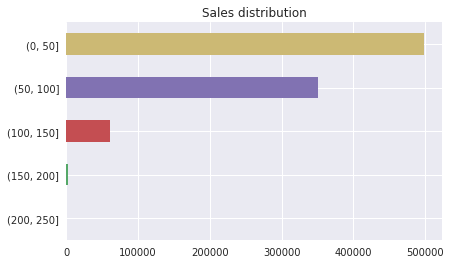

In [208]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

As we can see, almost 92% of sales are less than 100. Max, min and average sales are 231, 0 and 52.25 respectively.   
So any prediction model has to deal with the skewness in the data appropriately. 

## How does sales vary across stores
Let us get a overview of sales distribution in the whole data.
We have just one store location for now

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      21.981599  58.574151  36.642223  22.010241  18.358708  58.503888   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      58.531051  76.950055  51.389869  73.227437    ...      22.002136   

                                                                         \
item          42         43         44         45         46         47   
store                                                                     
1      36.688116  51.294359  29.398193  80.584173  58.639869  22.003341   

                                        
item          48         49         50  
store                                   
1      51.352848  29.335323  65.882202  

[1 rows x 50 columns]

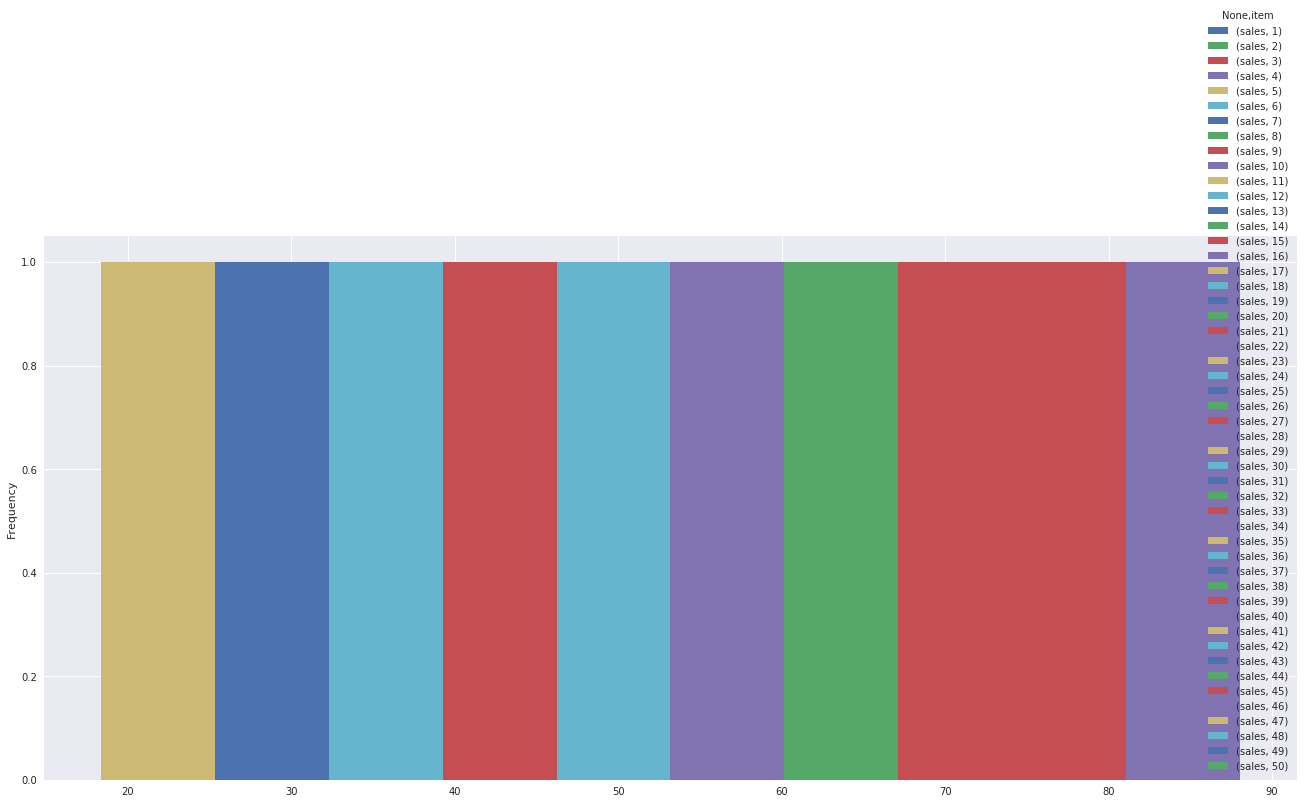

In [209]:
# Let us understand the sales data distribution across the stores
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!

In [210]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [211]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')



## How does sales vary across items

In [212]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

item   avg_sale
14    15  88.030778
27    28  87.881325
12    13  84.316594
17    18  84.275794
24    25  80.686418

Let us visualize these average sales per item!

In [213]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

The sales is uniformly distributed across all the items.   
Top items with highest average sale are 15, 28, 13, 18 and with least average sales are 5, 1, 41 and so on.

## Time-series visualization of the sales
Let us see how sales of a given item in a given store varies in a span of 5 years.

In [214]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 1   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (18260, 4)


In [215]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [1, 1, 1, 1]   # Some stores
    item_ids = [10, 20, 30, 40]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (73040, 4)


# LIGHTGBM

In [216]:
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_df,test_df)

In [217]:
train_x.shape,train_y.shape,test_x.shape

((730400, 5), (730400,), (182600, 5))

In [218]:
# opt_params

In [219]:
%%time

def model(train_x,train_y,test_x,test_y,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_test = model.predict(test_df[col])
   
    return y_test,model

CPU times: user 980 µs, sys: 0 ns, total: 980 µs
Wall time: 990 µs


In [220]:
%%time


y_test, model = model(train_x,train_y,test_x,test_y,col)

Training until validation scores don't improve for 50 rounds.
[50]	training's mape: 0.249769	valid_1's mape: 0.251022
[100]	training's mape: 0.240403	valid_1's mape: 0.241864
[150]	training's mape: 0.237924	valid_1's mape: 0.239719
[200]	training's mape: 0.236958	valid_1's mape: 0.238887
[250]	training's mape: 0.236422	valid_1's mape: 0.238433
[300]	training's mape: 0.236163	valid_1's mape: 0.238261
[350]	training's mape: 0.236069	valid_1's mape: 0.238265
[400]	training's mape: 0.235854	valid_1's mape: 0.238104
[450]	training's mape: 0.235802	valid_1's mape: 0.238094
Early stopping, best iteration is:
[405]	training's mape: 0.235815	valid_1's mape: 0.23807
CPU times: user 1min 13s, sys: 3.9 s, total: 1min 17s
Wall time: 44.9 s


In [226]:
sample_df['sales'] = y_test
sample_df.to_csv('lgb_bayasian_param.csv', index=False)
sample_df['sales'].head()

0    13.713233
1    15.733033
2    15.666133
3    16.051594
4    17.959922
Name: sales, dtype: float64

In [227]:
from sklearn.externals import joblib
joblib.dump(model, 'salesmodel.pkl')

['salesmodel.pkl']

In [238]:
bringmod = joblib.load('salesmodel.pkl')
yy =bringmod.predict(test_x)

print("R2 score : %.2f" % r2_score(test_y, yy))

R2 score : 0.78


In [239]:

print("Mean squared error: %.2f" % mean_squared_error(test_y, yy))

Mean squared error: 186.05
